In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import trange

sys.path.append('../')

from examples.test_lds import main
from evaluations import gaussian_cdf_evaluation_PF, gaussian_cdf_evaluation_KF
from kalman_filtering import KalmanFilter, kalman_filtering_without_control
from environment_dynamics import LDSSimple

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
true_state_history, estimate_state_history, particle_history, weight_history, obs_history = main(
    seed=2, save_particles=True, num_iters=10, init="gaussian", num_particles=5000)

[array([10.10382531,  0.10691011]),
 array([9.59065942, 2.40184751]),
 array([8.9325681 , 4.56298567]),
 array([8.19319831, 7.9288611 ]),
 array([5.87029801, 9.00175991]),
 array([ 3.27544235, 10.25806609]),
 array([ 0.85956294, 11.54257725]),
 array([-2.51457953, 11.4065504 ]),
 array([-5.96304388, 10.53184242]),
 array([-8.81743182,  8.32983628])]

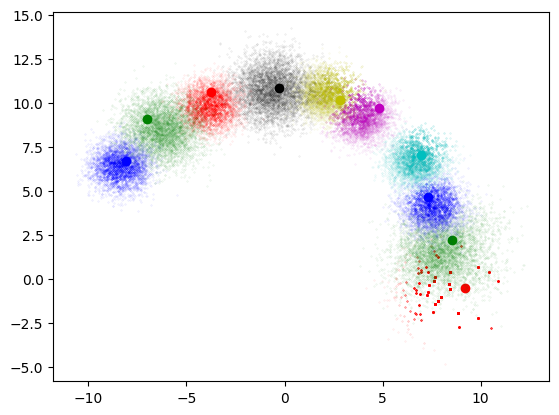

In [83]:
colors = 'rgbcmyk'
for i in range(10):
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.05, color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])


In [84]:
theta = np.pi / 12
A = np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

kf = KalmanFilter(A, C, Gamma, Sigma, mu0, Gamma0)

In [85]:
mu, V = kf.filtering(np.array(obs_history))

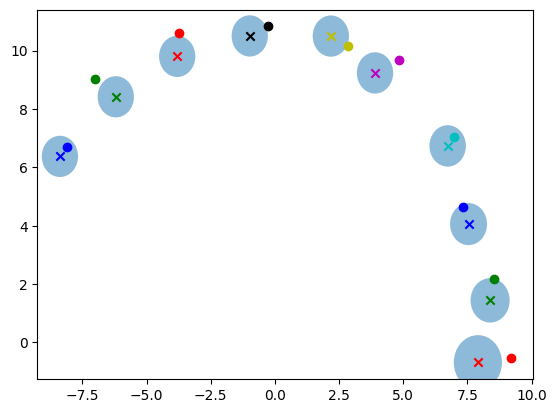

In [88]:
colors = 'rgbcmyk'
h = plt.subplot()
for i in range(10):
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])

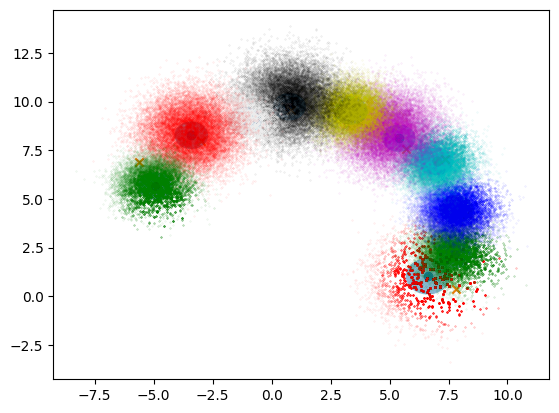

In [79]:
colors = 'rgbcmykw'



plt.scatter(mu[:, 0], mu[:, 1])
plt.scatter(np.array(true_state_history)[:, 0], np.array(true_state_history)[:, 1], marker="x")

for i in range(10):
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.05, color=colors[i%len(colors)])
    # plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)])

In [16]:
particle_history, weight_history, true_state_history = [], [], []
with trange(50, dynamic_ncols=True) as pbar:
    for i in pbar:
        true_state_history_temp, estimate_state_history, particle_history_temp, weight_history_temp, obs_history = main(save_particles=True, init="gaussian", 
                                                                                                                        num_iters=10, num_particles=10000)
        particle_history.append(particle_history_temp)
        weight_history.append(weight_history_temp)
        true_state_history.append(true_state_history_temp)
particle_history = np.concatenate(particle_history, axis=0)
weight_history = np.concatenate(weight_history, axis=0)
true_state_history = np.concatenate(true_state_history, axis=0)

100%|██████████| 50/50 [04:11<00:00,  5.04s/it]


In [17]:
particle_history.shape

(500, 10000, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


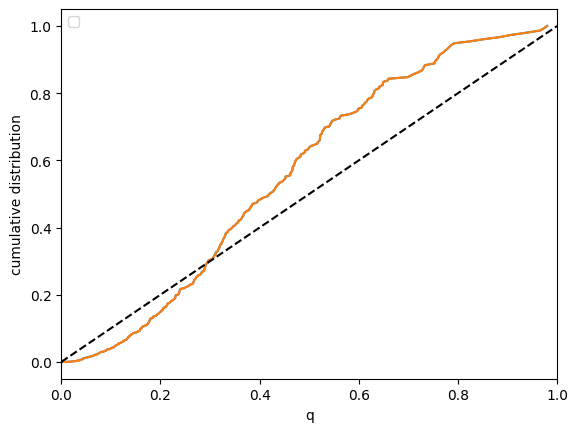

In [18]:
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history)

In [21]:
theta = np.pi / 12
A = np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

init_KF_kwargs = {
    "A": A, 
    "C": C, 
    "Sigma": Sigma, 
    "Gamma": Gamma, 
}

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

init_env_kwargs = {
    "A": A, 
    "C": C, 
    "Sigma": Sigma, 
    "Gamma": Gamma, 
    "mu0": mu0, 
    "Gamma0": Gamma0, 
}

true_state_history_KF = []
KF_mu_history = []
KF_cov_history = []

for i in range(100):
    mu, V, true_state = kalman_filtering_without_control(
        10, 
        env_cls=LDSSimple, 
        init_env_kwargs=init_env_kwargs, 
        init_KF_kwargs=init_KF_kwargs, 
    )
    
    true_state_history_KF.append(true_state)
    KF_mu_history.append(mu)
    KF_cov_history.append(V)

true_state_history_KF = np.array(true_state_history_KF)
KF_mu_history = np.array(KF_mu_history)
KF_cov_history = np.array(KF_cov_history)

In [22]:
cdf = []
for i in range(100):
    cdf.append(gaussian_cdf_evaluation_KF(
        KF_mu_history[i], 
        KF_cov_history[i], 
        true_state_history_KF[i], 
    ))

cdf = np.array(cdf)

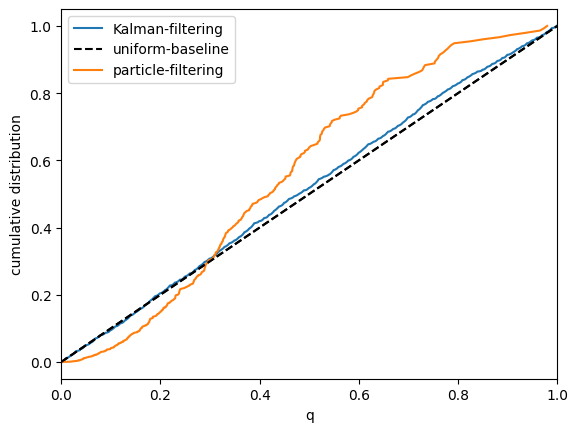

In [29]:
fig, ax = plt.subplots()
ax.plot(np.arange(1000) / 1000, np.cumsum(np.sort(cdf)) / np.sum(cdf), label="Kalman-filtering")
ax.plot(np.arange(1000) / 1000, np.arange(1000)* 0.001, "k--", label="uniform-baseline")
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history, ax=ax)

ax.legend()

In [25]:
np.cumsum(np.sort(cdf)) / np.sum(cdf)

array([2.87490781e-04, 7.30906242e-04, 1.20053789e-03, 1.68960792e-03,
       2.25651564e-03, 3.63828095e-03, 5.15031690e-03, 6.74227161e-03,
       8.48844253e-03, 1.05420184e-02, 1.09687285e-02, 1.14565258e-02,
       1.19682602e-02, 1.26459562e-02, 1.33870963e-02, 1.41872510e-02,
       1.50632601e-02, 1.62978599e-02, 1.77138853e-02, 1.94366086e-02,
       1.99226208e-02, 2.05888651e-02, 2.13765823e-02, 2.23325751e-02,
       2.33792015e-02, 2.44534099e-02, 2.57161117e-02, 2.73750698e-02,
       2.91212475e-02, 3.14273795e-02, 3.16680901e-02, 3.20201694e-02,
       3.23823733e-02, 3.27931639e-02, 3.32771875e-02, 3.37617935e-02,
       3.42701895e-02, 3.50683181e-02, 3.63779663e-02, 3.78926826e-02,
       3.84222898e-02, 3.91918325e-02, 3.99646675e-02, 4.09627621e-02,
       4.20876701e-02, 4.33182920e-02, 4.46153831e-02, 4.61089298e-02,
       4.77260894e-02, 4.94231681e-02, 4.96902310e-02, 5.00530662e-02,
       5.04683561e-02, 5.09047914e-02, 5.14830647e-02, 5.21676601e-02,
      